#  Minimizing the amount of correlations
*Author: Nicolas Quesada*

In [this paper](https://doi.org/10.1103/PhysRevA.88.044301) Jiang, Lang, and Caves [1] show that if one has two qumodes in local states $\left|\psi \right\rangle$ and $\left|\phi \right\rangle$, with zero displacement, and a beamsplitter $\text{BS}(\theta)$, then the only way no entanglement is generated when the beamsplitter acts on the product of the two states 

$$\left|\Psi  \right\rangle = \text{BS}(\theta) \ \left|\psi \right\rangle \otimes \left|\phi \right\rangle,$$

is if the states $\left|\psi \right\rangle$ and $\left|\phi \right\rangle$ are squeezed states along the same quadrature and by the same amount.

Now imagine the following task:
> Given an input state $\left|\psi \right\rangle$, which is not necessarily a squeezed state, what is the optimal state $\left|\phi \right\rangle$ incident on a beamsplitter $\text{BS}(\theta)$ together with $\left|\psi \right\rangle$ such that the resulting entanglement is minimized?

In our [paper](https://arxiv.org/abs/1805.06868) we showed that if $\theta \ll 1$ the optimal state $\left|\phi \right\rangle$, for any input state $\left|\psi \right\rangle$, is always a squeezed state.
We furthermore conjectured that this holds for any value of $\theta$.

Here, we numerically explore this question by performing numerical minimization over $\left|\phi \right\rangle$ to find the state that minimizes the entanglement between the two modes.

First, we import the libraries required for this analysis; NumPy, SciPy, TensorFlow, and StrawberryFields.

In [1]:
import numpy as np
from scipy.linalg import expm
import tensorflow as tf

/home/nicolas/anaconda2/envs/covarianceproject/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.backends.tfbackend.ops import partial_trace

Now, we set the Fock basis truncation; in this case, we choose $cutoff=30$:

In [3]:
cutoff = 30

## Creating the initial states

We define our input state $\newcommand{ket}[1]{\left|#1\right\rangle}\ket{\psi}$, an equal superposition of $\ket{0}$ and $\ket{1}$: $$\ket{\psi}=\frac{1}{\sqrt{2}}\left(\ket{0}+\ket{1}\right)$$

In [4]:
psi = np.zeros([cutoff], dtype=np.complex128)
psi[0] = 1.0
psi[1] = 1.0
psi /= np.linalg.norm(psi)

We can now define our initial random guess for the second state $\ket{\phi}$:

In [5]:
phi = np.random.random(size=[cutoff]) + 1j*np.random.random(size=[cutoff])
phi[10:] = 0.
phi /= np.linalg.norm(phi)
#phi = np.zeros([cutoff], dtype=np.complex128)
#phi[0] = np.sqrt(0.8)
#phi[2] = np.sqrt(0.2)
#phi /= np.linalg.norm(phi)

Next, we define the creation operator $\hat{a}$,

In [6]:
a = np.diag(np.sqrt(np.arange(1, cutoff)), k=1)

the number operator $\hat{n}=\hat{a}^\dagger \hat{a}$,

In [7]:
n_opt = a.T @ a

and the quadrature operators $\hat{x}=a+a^\dagger$, $\hat{p}=-i(a-a^\dagger)$.

In [8]:
# Define quadrature operators
x = a + a.T
p = -1j*(a-a.T)

We can now calculate the displacement of the states in the phase space, $\alpha=\langle \psi \mid\hat{a}\mid\psi\rangle$. The following function calculates this displacement, and then displaces the state by $-\alpha$ to ensure it has zero displacement.

In [9]:
def recenter(state):
    alpha = state.conj() @ a @ state
    disp_alpha = expm(alpha.conj()*a - alpha*a.T)
    out_state = disp_alpha @ state
    return out_state

First, let's have a look at the displacement of state $\ket{\psi}$ and state $\ket{\phi}$:

In [10]:
psi.conj().T @ a @ psi

(0.4999999999999999+0j)

In [11]:
phi.conj().T @ a @ phi

(1.3522608443612985-0.042163078019527456j)

Now, let's center them in the phase space:

In [12]:
psi = recenter(psi)
phi = recenter(phi)

Checking they now have zero displacement:

In [13]:
np.round(psi.conj().T @ a @ psi, 9)

0j

In [14]:
np.round(phi.conj().T @ a @ phi, 9)

(5e-09-0j)

## Performing the optimization

We can construct the variational quantum circuit, using Strawberry Fields:

In [15]:
eng, q = sf.Engine(2)

psi = tf.cast(psi, tf.complex64)
phi_var = tf.cast(tf.Variable(phi.real),tf.complex64) \
            + 1j*tf.cast(tf.Variable(phi.imag), tf.complex64)

in_state = tf.tensordot(psi, phi_var, axes=0)

with eng:
    Ket(in_state) | q
    BSgate(np.pi/4, 0) | q
    
state = eng.run('tf', cutoff_dim=cutoff, eval=False, modes=[1])

Here, we are initializing a TensorFlow variable `phi_var` representing the initial state of mode `q[1]`, which we will optimize over. Note that we take the outer product $\ket{in}=\ket{\psi}\otimes\ket{\phi}$, and use the `Ket` operator to initialise the circuit in this initial multimode pure state.

Finally, when we run the engine, we use the argument `modes=[1]` to return the state of mode `q[1]`.

We can now extract the density matrix of this state:

In [16]:
rhoB = state.dm()

The cost function contains the purity of the reduced density matrix

$$\text{Tr}(\rho_B^2),$$

and an extra penalty that forces the optimized state to have zero displacement; that is, we want to minimise the value 

$$\langle \hat{x}\rangle=\text{Tr}(\rho_B\hat{x}).$$

Finally, we divide by the $\text{Tr}(\rho_B)^2$ so that the state is always normalized.

In [17]:
penalty_strength = 10

In [18]:
cost = tf.cast(tf.real((tf.trace(rhoB @ rhoB)
                            -penalty_strength*tf.trace(rhoB @ x)**2
                            -penalty_strength*tf.trace(rhoB @ p)**2)
                       /(tf.trace(rhoB))**2), tf.float64)

We can now set up the optimization, to minimise the cost function:

In [19]:
optimizer = tf.train.AdamOptimizer()
minimize_op = optimizer.minimize(-cost)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Running the optimization process for 1201 reps:

In [21]:
reps = 1201

cost_progress = []

for i in range(reps):

    [_, cost_val, ket_val] = sess.run([minimize_op, cost, phi_var])
    # Stores cost at each step
    cost_progress.append(cost_val)

    # Prints progress
    if i % 50 == 0:
        print("Rep: {} Cost: {}".format(i, cost_val))

Rep: 0 Cost: 0.42198410630226135
Rep: 50 Cost: 0.4929472506046295
Rep: 100 Cost: 0.5860753655433655
Rep: 150 Cost: 0.6668696403503418
Rep: 200 Cost: 0.7199383974075317
Rep: 250 Cost: 0.7561484575271606
Rep: 300 Cost: 0.7840590476989746
Rep: 350 Cost: 0.8084002733230591
Rep: 400 Cost: 0.831315279006958
Rep: 450 Cost: 0.8537018299102783
Rep: 500 Cost: 0.875950813293457
Rep: 550 Cost: 0.8982120156288147
Rep: 600 Cost: 0.9118286967277527
Rep: 650 Cost: 0.9122047424316406
Rep: 700 Cost: 0.9122297167778015
Rep: 750 Cost: 0.9122351408004761
Rep: 800 Cost: 0.912236213684082
Rep: 850 Cost: 0.9122364521026611
Rep: 900 Cost: 0.9122364521026611
Rep: 950 Cost: 0.9122365713119507
Rep: 1000 Cost: 0.9122365713119507
Rep: 1050 Cost: 0.9122366905212402
Rep: 1100 Cost: 0.9122366905212402
Rep: 1150 Cost: 0.9122365713119507
Rep: 1200 Cost: 0.9122365117073059


We can see that the optimization converges to the optimum purity value of 0.9122365.

## Visualising the optimum state

We can now calculate the density matrix of the input state $\ket{\phi}$ which minimises entanglement:

$$\rho_{\phi} = \ket{\phi}\left\langle \phi\right|$$

In [22]:
out_rhoB = np.outer(ket_val, ket_val.conj())

Next, we can use the following function to plot the Wigner function of this density matrix:

In [23]:
def wigner(rho, xvec, pvec):
    # Modified from qutip.org
    Q, P = np.meshgrid(xvec, pvec)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

In [24]:
# Import plotting
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
ket_val /= np.linalg.norm(ket_val)

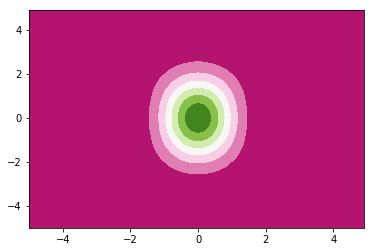

In [26]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
X, P, W = wigner(out_rhoB, x, p)
plt.contourf(X, P, np.round(W,3), cmap="PiYG")

We see that the optimal state is indeed a (mildly) squeezed state. This can be confirmed by visuallising the Fock state probabilities of state $\ket{\phi}$:

<Container object of 30 artists>

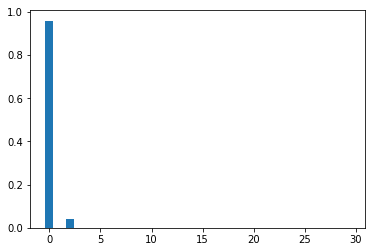

In [27]:
plt.bar(np.arange(cutoff), height=np.abs(ket_val)**2)

Finally, printing out the mean number of photons $\bar{n} = \left\langle \phi \mid \hat{n} \mid \phi\right\rangle$, as well as the squeezing magnitude $r=\sinh^{-1}\left(\sqrt{\bar{n}}\right)$ of this state:

In [28]:
nbar = ((ket_val.conj()).T @ n_opt @ ket_val).real
print("mean number of photons =",nbar)
print("squeezing parameter =",np.arcsinh(np.sqrt(nbar)))

mean number of photons = 0.08369976802526438
squeezing parameter = 0.2854181138560496



## References
[1] Jiang, Z., Lang, M. D., & Caves, C. M. (2013). Mixing nonclassical pure states in a linear-optical network almost always generates modal entanglement. *Physical Review A*, 88(4), 044301.

[2] Quesada, N., & Brańczyk, A. M. (2018). Gaussian functions are optimal for waveguided nonlinear-quantum-optical processes.  *arXiv:1805.06868*.